In [4]:
import pandas as pd
import requests
from urllib.parse import urlencode 
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
%matplotlib inline

In [5]:
# Создание списка с ссылками на Я.Диск на котором хранятся необходимые данные
public_key = ['https://disk.yandex.ru/d/PBW7aUHGuodFDA',
              'https://disk.yandex.ru/d/m0Z6QYNT46f9tQ',
              'https://disk.yandex.ru/d/lsmdbYB0iM7p3w',
              'https://disk.yandex.ru/d/Yse4Y6RJqg_WaA']

In [6]:
# импорт данных с помощью цикла
for i in range(len(public_key)):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url = base_url + urlencode(dict(public_key=public_key[i]))
    response = requests.get(final_url) 
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    if i == 0: 
        assessments = pd.read_csv(download_url, sep=',')
    elif i == 1: 
        courses = pd.read_csv(download_url, sep=',')
    elif i == 2:
        studentAssessment = pd.read_csv(download_url, sep=',')
    else:
        studentRegistration = pd.read_csv(download_url, sep=',')

In [7]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [8]:
courses.head()

,code_module,code_presentation,module_presentation_length
0,AAA,2013J,268
1,AAA,2014J,269
2,BBB,2013J,268
3,BBB,2014J,262
4,BBB,2013B,240


In [9]:
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [10]:
studentRegistration.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


In [11]:
# Объединение двух датафреймов по общей колонке id_assessment. Понадобится в дальнейшем
StAsFull = studentAssessment.merge(assessments, how = 'inner', on = 'id_assessment')

При первичном просмотре данных, наверное, самой большой аномалией является то, что фактически данные по сдаче экзаменов присутствуют только по двум предметам. Есть предположение, что часть данных касающихся сдачи экзаменов не было загружено в соответствующий файл. Показательным на мой взгляд является предмет GGG, в котором все тесты на ПК и сдачи преподавателю ни как не влияют на оценку за курс, т.к. не имеют веса (weight), оценка за предмет GGG целиком складывается из одного экзамена. При этом большинство студентов сдают тесты преподавателю и с помощью ПК, но ни один из них не сдавал экзамен, который целиком влияет на оценку. 

In [12]:
assessments.query("code_module == 'GGG'").head(10)

,code_module,code_presentation,id_assessment,assessment_type,date,weight
176,GGG,2013J,37418,CMA,229.0,0.0
177,GGG,2013J,37419,CMA,229.0,0.0
178,GGG,2013J,37420,CMA,229.0,0.0
179,GGG,2013J,37421,CMA,229.0,0.0
180,GGG,2013J,37422,CMA,229.0,0.0
181,GGG,2013J,37423,CMA,229.0,0.0
182,GGG,2013J,37415,TMA,61.0,0.0
183,GGG,2013J,37416,TMA,124.0,0.0
184,GGG,2013J,37417,TMA,173.0,0.0
185,GGG,2013J,37424,Exam,229.0,100.0


In [13]:
StAsFull.query("code_module == 'GGG' and id_student == 559919")

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
158693,37415,559919,60,0,90.0,GGG,2013J,TMA,61.0,0.0
159634,37416,559919,123,0,75.0,GGG,2013J,TMA,124.0,0.0
160410,37417,559919,221,0,80.0,GGG,2013J,TMA,173.0,0.0
160894,37418,559919,94,0,100.0,GGG,2013J,CMA,229.0,0.0
161765,37419,559919,167,0,60.0,GGG,2013J,CMA,229.0,0.0
162489,37420,559919,209,0,100.0,GGG,2013J,CMA,229.0,0.0
162955,37421,559919,210,0,100.0,GGG,2013J,CMA,229.0,0.0
163717,37422,559919,210,0,80.0,GGG,2013J,CMA,229.0,0.0
164306,37423,559919,213,0,100.0,GGG,2013J,CMA,229.0,0.0


 Задание №1. Сколько студентов успешно сдали только один курс? (Успешная сдача — это зачёт по курсу на экзамене).
 
 Решение: 
 Нахождение количества студентов сдавших только один курс.
 Успешная сдача — это зачёт по курсу на экзамене. Зачёт ставится если оценка >= 40.
 1. Фильтрация данных по значению Exam в колонке с типом тестов + фильтр по по значениям >= 40 в колнке с оценками за тест.
 2. Создание списка студентов, которые смогли сдать экзамены по курсу и отсев тех, которые успешно сдали более 1 курса.
 3. Определение количества студентов сдавших только один курс.

Отввет: 3802

In [14]:
NumPassedOneCourse = StAsFull.query("assessment_type == 'Exam' and score >= 40.0") \
                             .groupby('id_student', as_index = False) \
                             .agg({'assessment_type':'count'}) \
                             .query("assessment_type == 1") \
                             .id_student \
                             .count()
NumPassedOneCourse

3802

Задание №2. Выяви самый сложный и самый простой экзамен: найди курсы и экзамены в рамках курса, которые обладают самой низкой и самой высокой завершаемостью*.

Решение: 
*завершаемость = кол-во успешных экзаменов / кол-во всех попыток сдать экзамен
Примем, что курс = курс по предмету = code_module
Экзамен в рамках курса = id_assessment 
1. Найдём для каждого уникального id_assessment количество сдававших Экзамен (Exam)
2. Найдём для каждого уникального id_assessment количество успешно сдавших Экзамен (Exam) - score >= 40
3. Найдём завершаемость курса в конкретных семестрах
4. Проделаем аналогичные действи для уникальных предметов (code_module)

Ответ: Самая высокая завершаемость по курсу предмета DDD = 0,89
       Самая низкая завершаемость по курсу предмета ССС = 0,88
       
       Самая высокая завершаемость в семестре 2014B по курсу предмета DDD = 0,93
       Самая низкая завершаемость в семестре 2013B по курсу предмета DDD = 0,84

In [15]:
# Отфильтруем таблицу StAsFull по типу теста Exam
# В дальнейшем нам в основном понадобятся данные касаемые только экзаменов
StAsExam = StAsFull.query("assessment_type == 'Exam'")
StAsExam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0


In [16]:
# Проверим количество и номера уникальных assessment в получившемся df
StAsExam.id_assessment.unique()

array([24290, 24299, 25340, 25354, 25361, 25368])

In [17]:
StAsExam.id_assessment.nunique()

6

In [18]:
# кол-во сдававших экзамены
numStExam = StAsExam.groupby(['code_module', 'code_presentation']).agg({'score':'count'})

In [19]:
# кол-во успехов 
numStExamPassed = StAsExam.query("score >= 40.0") \
                          .groupby(['code_module', 'code_presentation', 'id_assessment']) \
                          .agg({'score':'count'}) 

In [20]:
# завершаемость для каждого семестра по предметам
finalizability = numStExamPassed/numStExam 
finalizability.round(2)

score
code_module code_presentation id_assessment       
CCC         2014B             24290           0.89
            2014J             24299           0.87
DDD         2013B             25340           0.84
            2013J             25354           0.91
            2014B             25361           0.93
            2014J             25368           0.89

In [21]:
# кол-во сдававших экзамены (группировка только по предмету)
numStExamMod = StAsExam.groupby(['code_module']).agg({'score':'count'}) 

In [22]:
# успех
numStExamPassedMod = StAsExam.query("score >= 40.0").groupby(['code_module']).agg({'score':'count'}) 

In [23]:
# завершаемость для каждого предмета
finalizabilityMod = numStExamPassedMod/numStExamMod
finalizabilityMod.round(2)

,score
code_module,
CCC,0.88
DDD,0.89


Задание №3. По каждому предмету определи средний срок сдачи экзаменов (под сдачей понимаем последнее успешное прохождение экзамена студентом).

Решение: 
1. Проверить есть ли студенты, которые успешно сдавали экзамены 2 и более раз
2. Удалить лишние строчки
3. Посчитать средний срок сдачи экзаменов

Ответ: Средний срок сдачи экзамена по предмету CCC = 239 дней (округлено до целого)
       Средний срок сдачи экзамена по предмету DDD = 238 дней (округлено до целого)

In [24]:
# проверка наличия студентов, которые два и более раз успешно сдавали экзамен
test10 = StAsExam.query("score >= 40.0").groupby(['code_module','id_student'], as_index = False).agg({'score':'count'})
test10.query("score > 1")

,code_module,id_student,score
2591,DDD,540758,2
3181,DDD,593903,2
3339,DDD,605118,2


In [25]:
#средний срок сдачи экзаменов (учтена только последняя сдача экзамена, для студентов сдавших успешно в 2х семестрах)
AvExDdln = StAsExam.query("score >= 40.0") \
                .drop_duplicates(subset=['id_student', 'code_module', 'assessment_type'], keep='last') \
                .groupby(['code_module'], as_index = False) \
                .agg({'date_submitted':'mean'}) \
                .rename(columns={'date_submitted':'mean_days'}).round(0)
AvExDdln

,code_module,mean_days
0,CCC,239.0
1,DDD,238.0


Задание №4. Выяви самые популярные курсы (ТОП-3) по количеству регистраций на них. А также курсы с самым большим оттоком (ТОП-3).

Решение:
1. Проведём группировку-аггрегацию-сортировку-вывод топ-3 количеству регистраций по каждому из предметов
2. Проведём группировку-аггрегацию-сортировку-вывод топ-3 количеству отчислений по каждому из предметов
3. Вычислим процент оттока относительно регистраций по каждому из предметов

Ответ: ТОП-3 предметов по количеству регистраций на курсы: BBB, FFF, DDD 
       ТОП-3 предметов с самым большим оттоком в абсолютных значениях: FFF, BBB, DDD
       ТОП-3 предметов с самым большим оттоком в % относительно регистраций: CCC, DDD, FFF

In [26]:
studentRegistration.groupby('code_module', as_index = False) \
                   .agg({'date_registration':'count'}) \
                   .sort_values('date_registration', ascending=False) \
                   .head(3)

,code_module,date_registration
1,BBB,7900
5,FFF,7751
3,DDD,6257


In [27]:
studentRegistration.groupby('code_module', as_index = False) \
                   .agg({'date_unregistration':'count'}) \
                   .sort_values('date_unregistration', ascending=False) \
                   .head(3)

,code_module,date_unregistration
5,FFF,2380
1,BBB,2377
3,DDD,2235


In [28]:
persent_unreg = studentRegistration.groupby('code_module')\
          .agg({'date_registration':'count', 'date_unregistration':'count'})\
          .rename(columns={'date_registration':'reg'})\
          .rename(columns={'date_unregistration':'unreg'})\
          .reset_index()
persent_unreg['persent_unreg']=((persent_unreg.unreg/persent_unreg.reg)*100).round(1)
persent_unreg.sort_values('persent_unreg', ascending = False).head(3)

,code_module,reg,unreg,persent_unreg
2,CCC,4426,1947,44.0
3,DDD,6257,2235,35.7
5,FFF,7751,2380,30.7


Задание №5. Напиши функцию на python, позволяющую строить когортный (семестровый) анализ. В период с начала 2013 по конец 2014 выяви семестр с самой низкой завершаемостью курсов и самыми долгими средними сроками сдачи курсов. Описание подхода можно найти тут.

Решение: 
1. Произведём сегментацию данных по колонке code_presentation, т.к. она явным образом намекает на год обучения. 
2. Сделаем графическое отображение с помощью seaborn.heatmap
3. Поместим код в оболочку функции

Ответ:  Семестр с самой низкой завершаемостью курсов - DDD 2014B
        Cеместр самыми долгими средними сроками сдачи курсов - CCC 2014J

In [29]:
def SemestrAnalys():
    # создание таблицы в которой с помощью переворота сделаны колонки с заголовками названий предметов.
    # в самой таблице значения завершаемости курсов (кол-во успешных экзаменов в семестре / кол-во всех попыток сдать экзамен в семестре)
    test12 = StAsExam.groupby(['code_presentation', 'code_module']) \
                             .agg({'score':'count'}).rename(columns={'score':'count_students'})
    test13 = StAsExam.query("score >= 40.0").groupby(['code_presentation', 'code_module']) \
                             .agg({'score':'count'}).rename(columns={'score':'count_students'})
    test14 = test13/test12
    test14_1 = test14.rename(columns={'count_students':'percent'}).reset_index()
    test14_2 = test14_1.pivot(index='code_presentation', columns='code_module', values='percent')
    # графическое отображение таблицы 
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(18,7))
    ax1 = sns.heatmap(test14_2,ax = axes[0], mask=test14_2.isnull(), annot=True, fmt='.0%', cmap='bwr')
    ax1.set_title('Completed')
    # создание таблицы с данными по среднему времени сдачи курсов
    test15 = StAsExam.query("score >= 40.0").groupby(['code_presentation', 'code_module'], as_index=False) \
                         .agg({'date_submitted':'mean'}).rename(columns={'date_submitted':'mean_ds'}).round(0)
    test15_1 = test15.pivot_table(index='code_presentation', columns='code_module',values='mean_ds')
    # графическое отображение таблицы
    ax2 = sns.heatmap(test15_1, ax = axes[1], annot=True,fmt='.0f', cmap='PiYG')
    ax2.set_title('Mean_duration')    

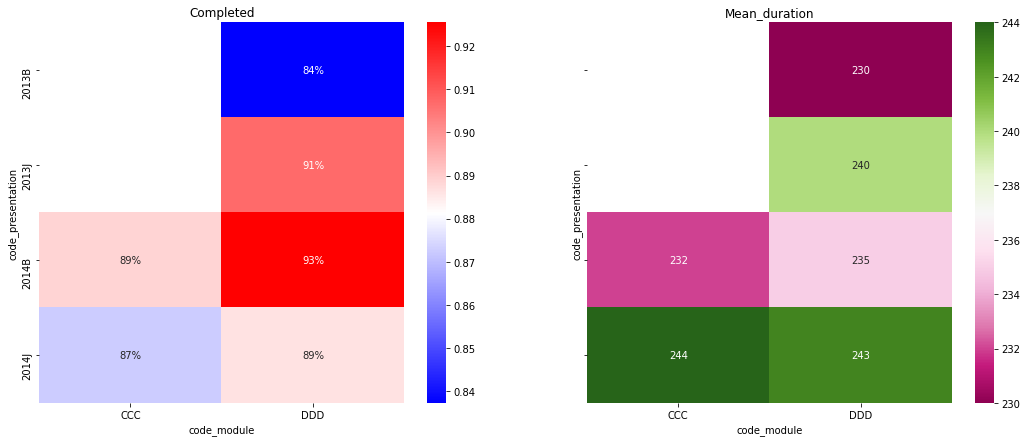

In [30]:
SemestrAnalys()

Задание №6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй адаптированные RFM-кластеры студентов, чтобы качественно оценить свою аудиторию. В адаптированной кластеризации можешь выбрать следующие метрики: R - среднее время сдачи одного экзамена, F - завершаемость курсов, M - среднее количество баллов, получаемое за экзамен. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 0.1 до 0.5, monetary от 55 до 72 баллов. 

Решение: Исходя из данных можем предположить, что маркировка J & B для семестров может указывать, на уровень предварительной подготовки студентов или программу ускоренного курса, т.к. во всех случаях длина семестров B меньше на 20-30 дней чем J. По этому на мой взгляд некорректно сравнивать время сдачи экзаменов. Интереснее ввести метрику, которая отразит за сколько/через сколько дней до/после дэдлайна был сдан экзамен. 
А возможно это были курсы производства виски J&B. И расшифровка семестров Justerini and Brooks.
1. Метрика R - за какое время до дедлайна была попытка сдачи экзамена
2. Метрика F - завершаемость экзаменаб применимо к конкретному студенту
3. Метрика М - балл полученый при попытке сдачи экзамена. Средний балл для студентов сдававших два и более экзаменов.

Для метрики R выберем следующую сегментацию:
delta_time меньше 0 
delta_time от 0 до 14 включительно
delta_time от 15 до 22 включительно
delta_time от 23 и больше

Сегментация метрики F по трём вариантам:
exam_succes = 0 провалены все экзамены
exam_succes = 0.5 успешно сдан один экзамен из двух
exam_succes = 1 успешно сданы все экзамены

Для метрики M выберем следующую сегментацию:
mean_score меньше 40
mean_score от 40 до 66 включительно (выбран по 50-му процентилю)
mean_score от 67 до 94 включительно
mean_score от 95 и выше (выбран из-за выброса на гистограмме в районе этих значений)

Ответ: Основная часть учащихся (80%) принадлежит к сегментам x12 (~40%) и x13 (~40%) (x = 1,2,3), т.е. большинство учащихся сдают экзамены до дэдлайна, студенты сдают в основном 1 экзамен (т.е. фокусируются на одном предмете), также понятно, что большинство учащихся успешно сдают экзамены.

Из ближайших перспектив развития видится изменения соотношения сегментов x12 и x13 в пользу первого. Т.е. увеличение процента студентов получающих при сдаче экзамена 66 баллов и выше.

In [31]:
# Объединение двух датафреймов по общей колонкам code_presentation и code_module для соспоставления длины курсов и дедлайна по Exam

deadline = assessments.merge(courses, how = 'inner', on = ['code_module', 'code_presentation']) \
                    .query("assessment_type == 'Exam' and (code_module == 'CCC' or code_module == 'DDD')")
deadline
# Из полученной таблицы можем предположить, что длина курса совпадает с дедлайном по сдаче экзамена

,code_module,code_presentation,id_assessment,assessment_type,date,weight,module_presentation_length
62,CCC,2014B,24290,Exam,NaN,100.0,241
63,CCC,2014B,40087,Exam,NaN,100.0,241
72,CCC,2014J,24299,Exam,NaN,100.0,269
73,CCC,2014J,40088,Exam,NaN,100.0,269
87,DDD,2013B,25340,Exam,240.0,100.0,240
94,DDD,2013J,25354,Exam,261.0,100.0,261
101,DDD,2014B,25361,Exam,241.0,100.0,241
108,DDD,2014J,25368,Exam,NaN,100.0,262


In [34]:
R_DeltaExamTime = StAsExam.merge(courses, how = 'inner', on = ['code_module', 'code_presentation'])
R_DeltaExamTime['delta_time'] = R_DeltaExamTime.module_presentation_length - R_DeltaExamTime.date_submitted
R_DeltaExamTime.shape

(4959, 12)

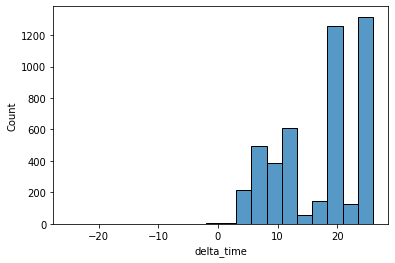

In [63]:
# гистограмма, для того чтобы определить сегменты
sns.histplot(R_DeltaExamTime, x = 'delta_time', bins=20)

Наблюдаются 3 выброса.
Для метрики R выберем следующую сегментацию:
delta_time меньше 0 
delta_time от 0 до 14 включительно
delta_time от 15 до 22 включительно
delta_time от 23 и больше


In [59]:
R_DeltaExamTime = R_DeltaExamTime[['id_student', 'delta_time']].groupby('id_student', as_index=False) \
                                                                .agg({'delta_time' : 'mean'})
R_DeltaExamTime.head()

,id_student,delta_time
0,23698,26.0
1,24213,5.0
2,27116,26.0
3,28046,24.0
4,28787,26.0


In [37]:
# Добавление колонки, которая будет показывать статус экзамена. True - успешно сдан, False - провален 
StAsExam['passed_exam'] = StAsExam.score >= 40

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [38]:
StAsExam.head()

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,passed_exam
52923,24290,558914,230,0,32.0,CCC,2014B,Exam,NaN,100.0,False
52924,24290,559706,234,0,78.0,CCC,2014B,Exam,NaN,100.0,True
52925,24290,559770,230,0,54.0,CCC,2014B,Exam,NaN,100.0,True
52926,24290,560114,230,0,64.0,CCC,2014B,Exam,NaN,100.0,True
52927,24290,560311,234,0,100.0,CCC,2014B,Exam,NaN,100.0,True


In [58]:
F_ExamSucces = StAsExam.groupby('id_student', as_index=False) \
                        .agg({'score': 'count', 'passed_exam':'sum'}) \
                        .rename(columns={'score': 'num_exams', 'passed_exam':'num_exams_passed'})
F_ExamSucces.sort_values('num_exams', ascending = False).head()

,id_student,num_exams,num_exams_passed
2316,588482,2,2
1216,507344,2,2
1225,509102,2,2
3465,645792,2,2
1251,512259,2,2


In [56]:
F_ExamSucces['exam_succes'] = F_ExamSucces.num_exams_passed / F_ExamSucces.num_exams
F_ExamSucces = F_ExamSucces.drop(['num_exams', 'num_exams_passed'], axis=1)

In [60]:
F_ExamSucces.head()

,id_student,num_exams,num_exams_passed
0,23698,1,1
1,24213,1,1
2,27116,1,1
3,28046,1,1
4,28787,1,1


In [42]:
M_score = StAsExam.groupby('id_student', as_index=False) \
                    .agg({'score': 'mean'}) \
                    .rename(columns={'score': 'mean_score'})
M_score.head()

,id_student,mean_score
0,23698,80.0
1,24213,58.0
2,27116,96.0
3,28046,40.0
4,28787,44.0


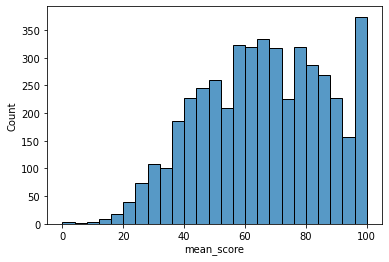

In [43]:
# гистограмма для того, чтобы определить каким образом сегментировать данные
sns.histplot(data=M_score, x="mean_score", bins=25)

In [44]:
# дополнительные данные для размышления о выборе сегментов данных
M_score.describe()

,id_student,mean_score
count,4.633000e+03,4633.000000
mean,7.256904e+05,65.117958
std,5.753498e+05,20.470561
min,2.369800e+04,0.000000
25%,5.011580e+05,50.000000
50%,5.884820e+05,66.000000
75%,6.463510e+05,82.000000
max,2.698251e+06,100.000000


Для метрики M выберем следующую сегментацию:
mean_score меньше 40
mean_score от 40 до 66 включительно (выбран по 50-му процентилю)
mean_score от 67 до 94 включительно
mean_score от 95 и выше (выбран из-за выброса на гистограмме в районе этих значений)

In [45]:
RFM = R_DeltaExamTime.merge(F_ExamSucces, on = 'id_student', how = 'outer') \
    .merge(M_score, on = 'id_student', how = 'outer')

In [46]:
# Объединение в одну таблицу всех метрик
RFM

,id_student,delta_time,exam_succes,mean_score
0,23698,26.0,1.0,80.0
1,24213,5.0,1.0,58.0
2,27116,26.0,1.0,96.0
3,28046,24.0,1.0,40.0
4,28787,26.0,1.0,44.0
...,...,...,...,...
4628,2694886,5.0,1.0,69.0
4629,2694933,10.0,1.0,73.0
4630,2695608,24.0,1.0,73.0
4631,2697181,11.0,1.0,80.0


In [47]:
RFM.exam_succes.value_counts()

1.0    4069
0.0     536
0.5      28
Name: exam_succes, dtype: int64

Сегментация метрики F по трём вариантам:
exam_succes = 0 провалены все экзамены
exam_succes = 0.5 успешно сдан один экзамен из двух
exam_succes = 1 успешно сданы все экзамены

In [48]:
def R(x):
    if x >= 23:
        return 1
    elif 23 > x >= 15:
        return 2
    elif 15 > x >= 0:
        return 3
    else:
        return 4

def F(x):
    if x == 1:
        return 1
    elif x == 0.5:
        return 2
    else:
        return 3
    
def M(x):
    if x >= 95:
        return 1
    elif x >= 67:
        return 2
    elif x >= 40:
        return 3
    else:
        return 4    

In [49]:
# Итоговая тамлица с маркированными кластерами
RFM['segment_RFM'] = RFM.delta_time.apply(R).map(str) + RFM.exam_succes.apply(F).map(str) + RFM.mean_score.apply(M).map(str)
RFM

,id_student,delta_time,exam_succes,mean_score,segment_RFM
0,23698,26.0,1.0,80.0,112
1,24213,5.0,1.0,58.0,313
2,27116,26.0,1.0,96.0,111
3,28046,24.0,1.0,40.0,113
4,28787,26.0,1.0,44.0,113
...,...,...,...,...,...
4628,2694886,5.0,1.0,69.0,312
4629,2694933,10.0,1.0,73.0,312
4630,2695608,24.0,1.0,73.0,112
4631,2697181,11.0,1.0,80.0,312


In [50]:
# таблица с процентным соотношением каждого сегмента в совокупности студентов сдававших экзамены
rfm = RFM['segment_RFM'].value_counts().to_frame().rename(columns={'segment_RFM': 'count_student'})
rfm['segment_RFM'] = rfm.index
rfm['persent'] = (rfm.count_student / RFM.shape[0] *100).round(2)
rfm

,count_student,segment_RFM,persent
312,696,312,15.02
212,680,212,14.68
313,665,313,14.35
213,617,213,13.32
112,518,112,11.18
113,500,113,10.79
334,207,334,4.47
134,167,134,3.60
234,160,234,3.45
311,145,311,3.13


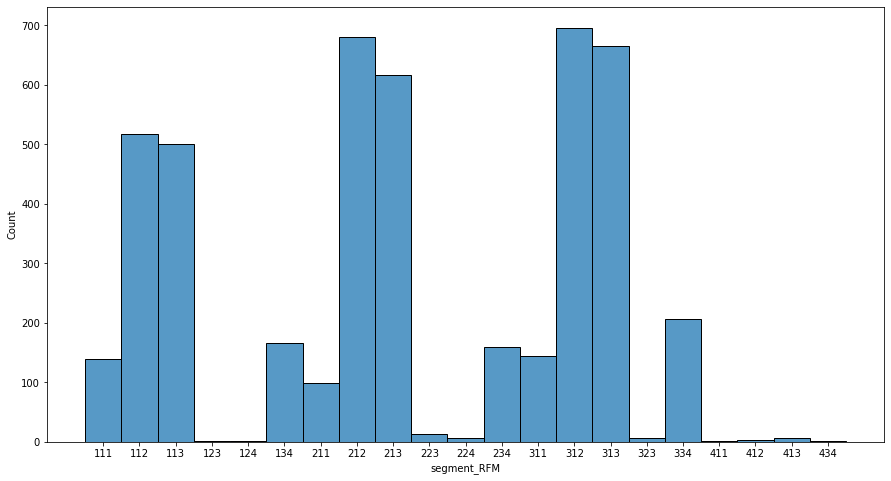

In [51]:
# гистограмма сегментов
plt.figure(figsize = (15,8))
sns.histplot(data=RFM.sort_values('segment_RFM'), x='segment_RFM')
